In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
cs = {}

cs["on"] = xhermes.open_hermesdataset(datapath = r"/ssd_scratch/hcases/a_general_neutral_mixed/nmx4c-original_neutadv_higherres_poloidal_on/BOUT.dmp.*.nc", info = False, unnormalise = False)
cs["off"] = xhermes.open_hermesdataset(datapath = r"/ssd_scratch/hcases/a_general_neutral_mixed/nmx4cb-original_neutadv_higherres_poloidal_off/BOUT.dmp.*.nc", info = False, unnormalise = False)
cs["on_mom_off"] = xhermes.open_hermesdataset(datapath = r"/ssd_scratch/hcases/a_general_neutral_mixed/nmx4cc-original_neutadv_higherres_poloidal_on_mom_off/BOUT.dmp.*.nc", info = False, unnormalise = False)


for case in cs:
    cs[case].load()


/ssd_scratch/scripts/xBOUT/xbout/geometries.py:225: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    cell_location:  CELL_CENTRE
    direction_y:    Standard
    direction_z:    Average
    source:         Coordinates
    metadata:       {'BOUT_VERSION': 5.2, 'Bnorm': 1.0, 'Cs0': 97871.51425755...
    options:        None
    geometry:        is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(
/ssd_scratch/scripts/xBOUT/xbout/geometries.py:225: UserWarning: Size of toroidal domain as calculated from nz*dz (<xarray.DataArray 'dz' ()>
dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Attributes:
    cell_location:  CELL_CENTRE
    direction_y:    Standard
    direction_z:    Average
    source:         Coordinates
    metadata:       {'BOUT_VERSION': 5.2, 'Bnorm': 1.0, 'Cs0': 97871.51425755

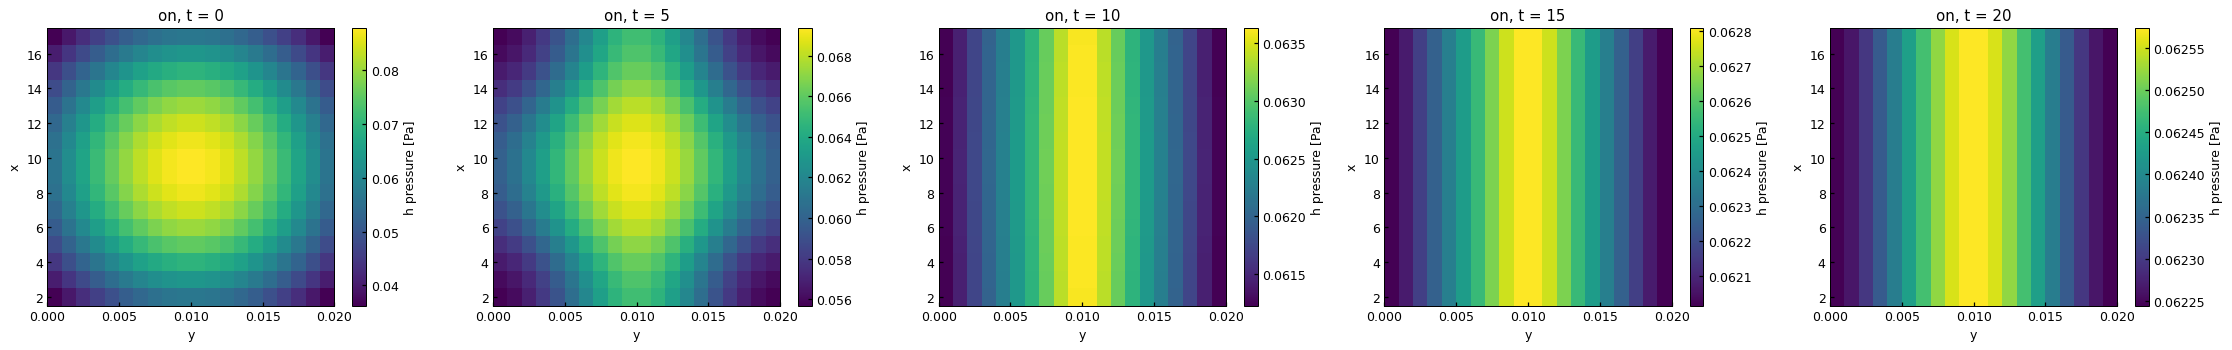

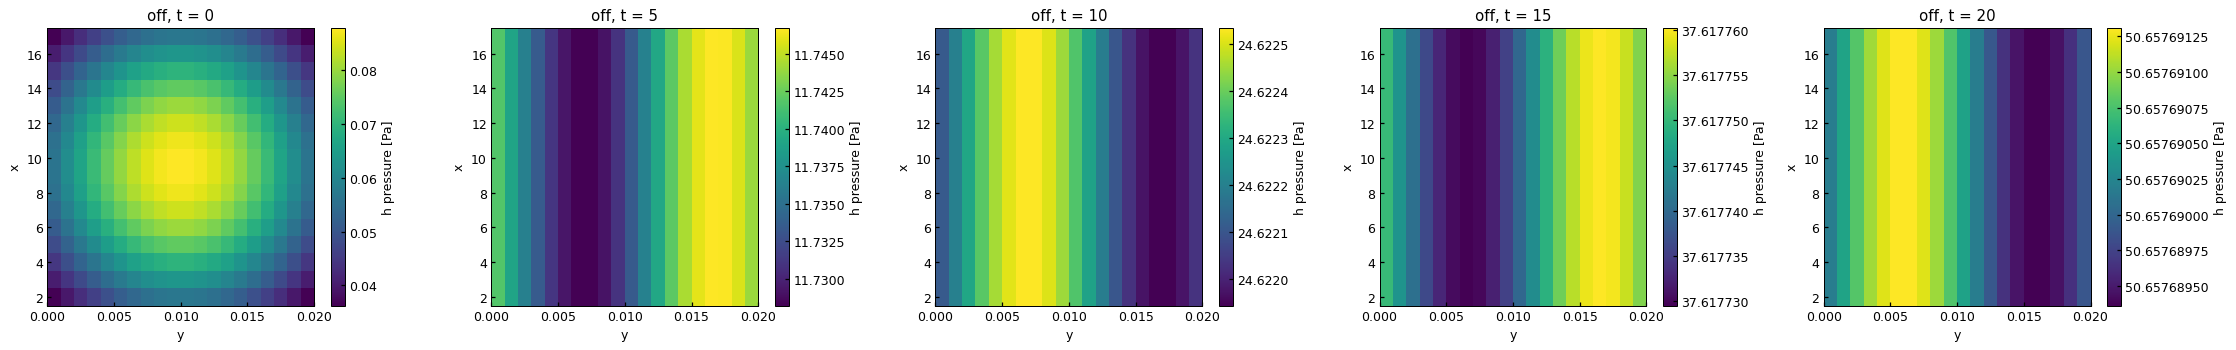

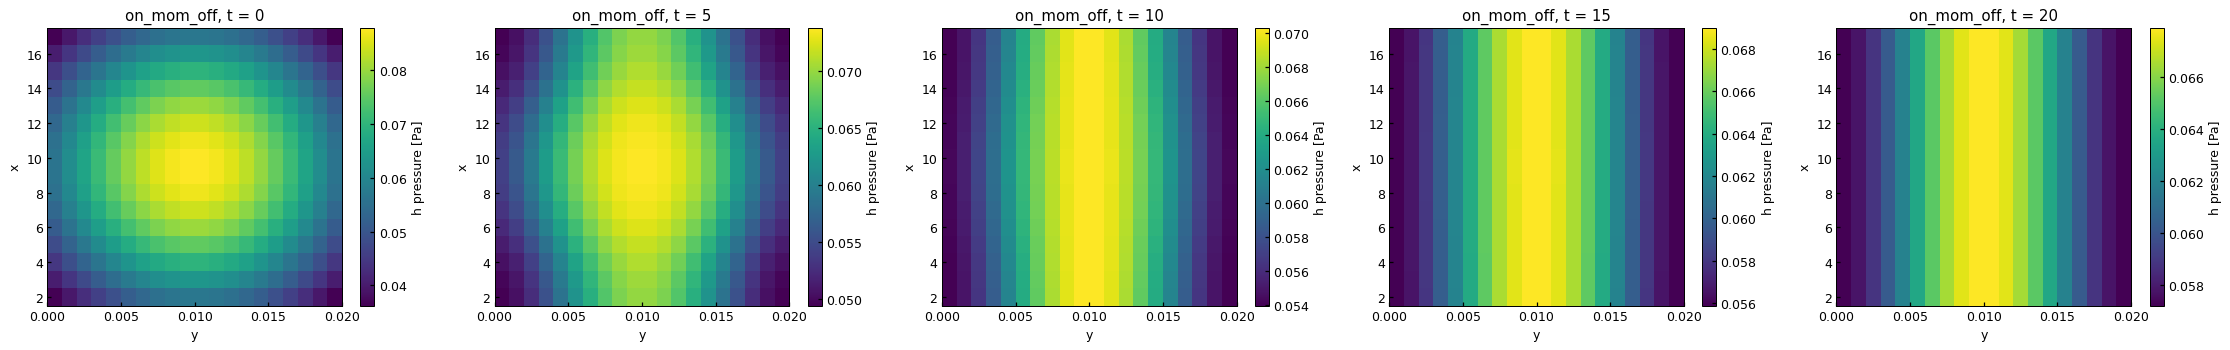

In [10]:
for name in cs:

    tlist = np.linspace(0,20, 5, dtype=int)

    fig, axes = plt.subplots(1, len(tlist), figsize = (5*len(tlist), 4), dpi = 90)

    for i, t in enumerate(tlist):
        ds = cs[name].isel(t=t, z = 5, x = slice(2,-2))
        ds["Ph"].plot(ax = axes[i], 
                      vmin = None, 
                      vmax = None
                      )

        axes[i].set_title(f"{name}, t = {t}")
        axes[i].grid(which="both", visible  = False)
        
    fig.tight_layout()

# Simulate test

In [ ]:
cs["upwind_fork"].dims

In [ ]:
ds = cs["master"]

ds.data_vars

In [ ]:
ds.dims

In [ ]:

for name in cs:
    fig, ax = plt.subplots()
    ds = cs[name].isel(t=-1, z = 5)
    ds["Nh"].plot(ax = ax)

In [ ]:
cs.keys()

In [ ]:
from boututils.run_wrapper import shell, shell_safe, launch_safe
from boutdata.collect import collect
from sys import stdout, exit
import numpy as np

shell("ln -s /ssd_scratch/hermes-3/build-mc-neutral-advection hermes-3")

# Run the case
s, out = launch_safe("./hermes-3", nproc=1, mthread=1, pipe=True)
with open("run.log", "w") as f:
  f.write(out)

# Collect the density and pressure
n = collect("Nh", path="data")
p = collect("Ph", path="data")

# Check that the density is not constant at the start
if np.amax(n[0,2:-2,:,:]) - np.amin(n[0,2:-2,:,:]) > 0.1:
    print("Density start test passed")
else:
    raise("Density start test FAILED")
# Check that the density is almost constant at the end
if np.amax(n[-1,2:-2,:,:]) - np.amin(n[-1,2:-2,:,:]) < 1e-3:
    print("Density end test passed")
else:
    print("Density end test FAILED")

# Total number of particles conserved
if abs(np.sum(n[-1, 2:-2,:,:]) - np.sum(n[0, 2:-2,:,:])) < 1e-3:
    print("Density conservation test passed")
else:
    print("Density conservation test FAILED")

# Total thermal energy decreasing (some lost to viscosity)
if np.sum(p[-1, 2:-2,:,:]) <= np.sum(p[0, 2:-2,:,:]):
    print("Thermal energy conservation test passed")
else:
    print("Thermal energy conservation test FAILED")

exit(0)

# All tests

In [ ]:
cs.keys()

In [ ]:
name = "orig_hires_noparvar"
ds = cs[name]
n = ds["Nh"].values
p = ds["Ph"].values

# Check that the density is not constant at the start
if np.amax(n[0,2:-2,:,:]) - np.amin(n[0,2:-2,:,:]) > 0.1:
    print("Density start test passed")
else:
    raise("Density start test FAILED")
# Check that the density is almost constant at the end
if np.amax(n[-1,2:-2,:,:]) - np.amin(n[-1,2:-2,:,:]) < 1e-3:
    print("Density end test passed")
else:
    print("Density end test FAILED")

# Total number of particles conserved
if abs(np.sum(n[-1, 2:-2,:,:]) - np.sum(n[0, 2:-2,:,:])) < 1e-3:
    print("Density conservation test passed")
else:
    print("Density conservation test FAILED")

# Total thermal energy decreasing (some lost to viscosity)
if np.sum(p[-1, 2:-2,:,:]) <= np.sum(p[0, 2:-2,:,:]):
    print("Thermal energy conservation test passed")
else:
    print("Thermal energy conservation test FAILED")

## Density range test

In [ ]:
cs.keys()

In [ ]:
fig, ax = plt.subplots()
spatial = ["x", "y", "z"]

for name in cs:
    ds = cs[name].isel(y = slice(2,-2))
    dens_range = ds["Nh"].max(spatial) - ds["Nh"].min(spatial) 
    ax.plot(dens_range, label = name)
    
xlims = ax.get_xlim()
ax.hlines(0.1, xlims[0], xlims[1], color = "black", linestyle = ":", label = "Start minimum")
ax.hlines(1e-3, xlims[0], xlims[1], color = "black", linestyle = "--", label = "End maximum")
    
ax.set_title("Density range")
ax.set_xlabel("Time")
ax.set_ylabel("$N_h^{max} - N_h^{min}$")
ax.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.15), ncols = 2)
ax.set_yscale("log")

## Particle conservation

In [ ]:
fig, ax = plt.subplots()
spatial = ["x", "y", "z"]

for name in cs:
    ds = cs[name].isel(x = slice(2,-2))

    ax.plot(dens_int, label = name)
    
xlims = ax.get_xlim()
# ax.hlines(0.1, xlims[0], xlims[1], color = "black", linestyle = ":", label = "Start minimum")
# ax.hlines(1e-3, xlims[0], xlims[1], color = "black", linestyle = "--", label = "End maximum")
    
ax.set_title("Particle conservation")
ax.set_xlabel("Time")
ax.set_ylabel("Density integral")
ax.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.15), ncols = 2)
# ax.set_yscale("log")

In [ ]:
cs.keys()

In [ ]:
ds = cs["orig_master"]
n = ds["Nh"].values

start = abs(np.sum(n[0, 2:-2,:,:]))
end = abs(np.sum(n[-1, 2:-2,:,:]))

print(f"Start: {start}")
print(f"End: {end}")

In [ ]:
ds.dims

In [ ]:

ds["Nh"].isel(t=0, x = slice(2,-2)).sum(spatial).values

## Thermal energy history

In [ ]:
fig, ax = plt.subplots()
spatial = ["x", "y", "z"]

for name in cs:
    ds = cs[name].isel(x = slice(2,-2))
    
    p_int = ds["Ph"].sum(spatial)
    ax.plot(p_int, label = name)
    
xlims = ax.get_xlim()
# ax.hlines(0.1, xlims[0], xlims[1], color = "black", linestyle = ":", label = "Start minimum")
# ax.hlines(1e-3, xlims[0], xlims[1], color = "black", linestyle = "--", label = "End maximum")
    
ax.set_title("Pressure integral")
ax.set_xlabel("Time")
ax.set_ylabel("Pressure integral")
ax.legend(loc = "upper left", bbox_to_anchor = (1,1))
ax.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.15), ncols = 2)
# ax.set_yscale("log")

# History plots

In [ ]:
%matplotlib inline

In [ ]:
for name in cs:

    tlist = np.linspace(0,len(cs[name]["t"])-1, 5, dtype=int)

    fig, axes = plt.subplots(1, len(tlist), figsize = (5*len(tlist), 4), dpi = 90)

    for i, t in enumerate(tlist):
        ds = cs[name].isel(t=t, z = 10, x = slice(2,-2))
        ds["Ph"].plot(ax = axes[i], 
                    #   vmin = 0.6, 
                    #   vmax = 1
                      )

        axes[i].set_title(f"{name}, t = {t}")
        axes[i].grid(which="both", visible  = False)
        
    fig.tight_layout()

In [ ]:
vmax = 0.062407814, vmin = 0.062407813

# Animations

In [ ]:
%matplotlib widget

In [ ]:
cs.keys()

In [ ]:
plt.close("all")

fig, ax = plt.subplots()

normtimeidx = 125

ds = cs["orig_hires_noparvar"]
anim = xbout.plotting.animate.animate_pcolormesh(ds["Nh"].isel(z=10, x = slice(2,-2)), ax = ax, 
                                                #  vmin = 0.65, vmax = 1,
                                                #  vmax = ds.isel(t=normtimeidx)["Nh"].max(), vmin = ds.isel(t=normtimeidx)["Nh"].min(),
                                                 x = "y"
                                                 )

ax.grid(False)
